In [1]:
import os
import random
import matplotlib.pyplot as plt

from datasets import load_from_disk
from PIL import Image
from utils import build_deepseek_ocr_sft_dataset

DATA_OUTPUT_DIR = "./data"

In [2]:

def load_or_create_dataset(data_path):
    if os.path.exists(data_path):
        print(f"Loading dataset from {data_path}")
        try:
            dataset = load_from_disk(data_path)
            print(f"Dataset loaded successfully with {len(dataset)} samples.")
            return dataset
        except Exception as e:
            print(f"Failed to load dataset from {data_path}: {e}")
            print("Recreating the dataset...")
    print("Creating new dataset...")
    dataset = build_deepseek_ocr_sft_dataset(max_samples=1000)
    dataset.save_to_disk(data_path)
    print(f"Dataset created and saved to {data_path} with {len(dataset)} samples.")
    
    return dataset

train_dataset = load_or_create_dataset(DATA_OUTPUT_DIR)

Loading dataset from ./data
Dataset loaded successfully with 1000 samples.


Displaying 5 random samples from the dataset:


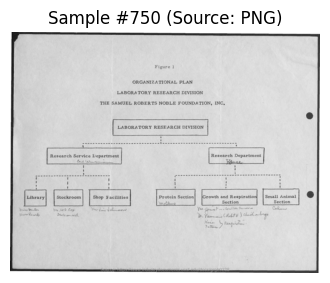

💬 [Dialogue Content for Sample #750]
image_size
(512, 398)
👤 USER: [🖼️ IMAGE_TOKEN]
Under which department 'Stockroom' is organized ?
Answer strictly based on the content shown in the image.
image_size
(512, 398)
🤖 ASSISTANT: Research Service Department
--------------------------------------------------------------------------------



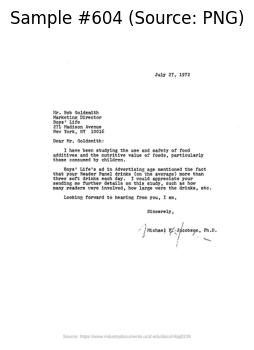

💬 [Dialogue Content for Sample #604]
image_size
(372, 512)
👤 USER: [🖼️ IMAGE_TOKEN]
Read the provided document image. What is the name of the addressee?
image_size
(372, 512)
🤖 ASSISTANT: Bob goldsmith
--------------------------------------------------------------------------------



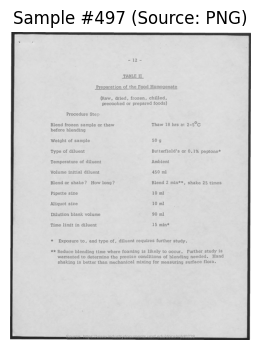

💬 [Dialogue Content for Sample #497]
image_size
(399, 512)
👤 USER: Please analyze this document:
[🖼️ IMAGE_TOKEN]
Query: What is the title of the table?
image_size
(399, 512)
🤖 ASSISTANT: preparation of the food homogenate
--------------------------------------------------------------------------------



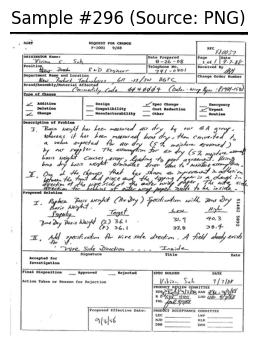

💬 [Dialogue Content for Sample #296]
image_size
(394, 512)
👤 USER: Please analyze this document:
[🖼️ IMAGE_TOKEN]
Query: Which is the ‘date prepared’?
image_size
(394, 512)
🤖 ASSISTANT: 8-26-88
--------------------------------------------------------------------------------



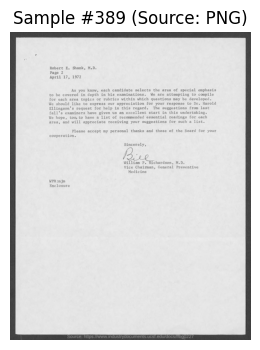

💬 [Dialogue Content for Sample #389]
image_size
(400, 512)
👤 USER: [🖼️ IMAGE_TOKEN]
what is the page no or page mentioned ?
Answer strictly based on the content shown in the image.
image_size
(400, 512)
🤖 ASSISTANT: page 2
--------------------------------------------------------------------------------



In [3]:
def display_random_samples(dataset, num_samples=5):
    """Display random samples from the dataset."""
    total_size = len(dataset)
    indices = random.sample(range(total_size), num_samples)
    print(f"Displaying {num_samples} random samples from the dataset:")
    for i, idx in enumerate(indices):
        sample = dataset[idx]
        image = sample['image']
        messages = sample['messages']
        
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Sample #{idx} (Source: {image.format})")
        plt.show()
        
        print(f"💬 [Dialogue Content for Sample #{idx}]")
        for msg in messages:
            role = msg['role'].upper()
            content = msg['content']
            
            print("image_size")
            print(image.size)
            display_content = content.replace("<image>", "[🖼️ IMAGE_TOKEN]")
            
            if role == "USER":
                print(f"👤 \033[94m{role}:\033[0m {display_content}")
            elif role == "ASSISTANT":
                print(f"🤖 \033[92m{role}:\033[0m {display_content}") 
        
        print("-" * 80 + "\n")


display_random_samples(train_dataset, num_samples=5)
    

In [4]:
import torch
print(torch.cuda.is_available())  
print(torch.__version__)

True
2.9.1+cu130


In [5]:
import sys
import math
import os
from PIL import Image, ImageOps
from transformers import AutoModel, AutoTokenizer

# 1. 设置环境与加载模型 (BF16)
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model_path = "deepseek-ai/DeepSeek-OCR"

print("Loading model...")
tokenizer = AutoTokenizer.from_pretrained(model_path, 
                                          use_fast=False,
                                          trust_remote_code=True)
model = AutoModel.from_pretrained(
    model_path, 
    trust_remote_code=True, 
    use_safetensors=True,
    torch_dtype=torch.bfloat16,
).cuda().to(torch.bfloat16).eval()

# 2. 【核心步骤】从模型源码模块中提取辅助函数
# 必须执行这一步，否则 infer_memory 里的 format_messages 等函数会报错找不到
remote_module = sys.modules[model.__module__]
format_messages = remote_module.format_messages
text_encode = remote_module.text_encode
dynamic_preprocess = remote_module.dynamic_preprocess
BasicImageTransform = remote_module.BasicImageTransform


@torch.no_grad()
def infer_memory(self, tokenizer, prompt, image_obj, base_size=1024, image_size=640, crop_mode=True):
    """
    Args:
        tokenizer: 模型的分词器
        prompt: 提示词 (str)
        image_obj: 内存中的 PIL Image 对象 (必填)
    Returns:
        str: 模型的生成结果
    """
    self.disable_torch_init()

    # 1. 构造 Conversation 结构 (主要是为了兼容 format_messages)
    # 这里的 images 列表留空或者是占位符即可，因为我们直接使用传入的 image_obj
    conversation = [
        {
            "role": "<|User|>",
            "content": f'{prompt}',
            "images": [], # 不需要路径了
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    
    # 调用原有的 format_messages 生成最终 prompt 字符串
    prompt_text = format_messages(conversations=conversation, sft_format='plain', system_prompt='')

    # 2. 直接使用传入的 PIL 对象，不再从磁盘加载
    images = [image_obj] 
    
    # ---------------- 以下是保留的核心预处理逻辑 ----------------
    patch_size = 16
    downsample_ratio = 4
    
    # 计算 ratio (用于动态分辨率调整)
    w, h = image_obj.size
    ratio = 1 - ((max(w, h) - min(w, h)) / (max(w, h)))

    # 初始化 Transform (假设上下文中已有 BasicImageTransform)
    image_transform = BasicImageTransform(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), normalize=True)
    
    image_token = '<image>'
    image_token_id = 128815 # 或者是 tokenizer.convert_tokens_to_ids('<image>')
    
    text_splits = prompt_text.split(image_token)
    
    images_list = []
    images_crop_list = []
    images_seq_mask = []
    tokenized_str = []
    images_spatial_crop = []

    # 遍历图片和文本片段 (通常只有一张图)
    for text_sep, image in zip(text_splits, images):
        
        # 文本编码
        tokenized_sep = text_encode(tokenizer, text_sep, bos=False, eos=False)
        tokenized_str += tokenized_sep
        images_seq_mask += [False] * len(tokenized_sep)

        if crop_mode:
            # 动态分辨率裁剪逻辑
            if image.size[0] <= 640 and image.size[1] <= 640:
                crop_ratio = [1, 1]
                images_crop_raw = [] # 小图不需要 crop
            else:
                images_crop_raw, crop_ratio = dynamic_preprocess(image)
            
            # Global View 处理
            global_view = ImageOps.pad(image, (base_size, base_size),
                                    color=tuple(int(x * 255) for x in image_transform.mean))
            
            images_list.append(image_transform(global_view).to(torch.bfloat16))

            width_crop_num, height_crop_num = crop_ratio
            images_spatial_crop.append([width_crop_num, height_crop_num])
            
            # Local Views 处理
            if width_crop_num > 1 or height_crop_num > 1:
                for i in range(len(images_crop_raw)):
                    images_crop_list.append(image_transform(images_crop_raw[i]).to(torch.bfloat16))
            
            # 插入 Image Tokens
            num_queries = math.ceil((image_size // patch_size) / downsample_ratio)
            num_queries_base = math.ceil((base_size // patch_size) / downsample_ratio)

            tokenized_image = ([image_token_id] * num_queries_base + [image_token_id]) * num_queries_base
            tokenized_image += [image_token_id]
            
            if width_crop_num > 1 or height_crop_num > 1:
                tokenized_image += ([image_token_id] * (num_queries * width_crop_num) + [image_token_id]) * (
                            num_queries * height_crop_num)
                            
            tokenized_str += tokenized_image
            images_seq_mask += [True] * len(tokenized_image)

        else:
            # 非 Crop 模式 (简单 Resize)
            global_view = ImageOps.pad(image, (image_size, image_size),
                                    color=tuple(int(x * 255) for x in image_transform.mean))
            images_list.append(image_transform(global_view).to(torch.bfloat16))
            
            width_crop_num, height_crop_num = 1, 1
            images_spatial_crop.append([width_crop_num, height_crop_num])

            num_queries = math.ceil((image_size // patch_size) / downsample_ratio)
            tokenized_image = ([image_token_id] * num_queries + [image_token_id]) * num_queries
            tokenized_image += [image_token_id]
            tokenized_str += tokenized_image
            images_seq_mask += [True] * len(tokenized_image)

    # 处理最后一段文本
    tokenized_sep = text_encode(tokenizer, text_splits[-1], bos=False, eos=False)
    tokenized_str += tokenized_sep
    images_seq_mask += [False] * len(tokenized_sep)

    # 添加 BOS Token
    bos_id = 0 # 或者是 tokenizer.bos_token_id
    tokenized_str = [bos_id] + tokenized_str 
    images_seq_mask = [False] + images_seq_mask

    # 转 Tensor
    input_ids = torch.LongTensor(tokenized_str)
    images_seq_mask = torch.tensor(images_seq_mask, dtype=torch.bool)

    if len(images_list) == 0:
        images_ori = torch.zeros((1, 3, image_size, image_size))
        images_spatial_crop = torch.zeros((1, 2), dtype=torch.long)
        images_crop = torch.zeros((1, 3, base_size, base_size))
    else:
        images_ori = torch.stack(images_list, dim=0)
        images_spatial_crop = torch.tensor(images_spatial_crop, dtype=torch.long)
        if images_crop_list:
            images_crop = torch.stack(images_crop_list, dim=0)
        else:
            images_crop = torch.zeros((1, 3, base_size, base_size))

    # 3. 生成 (Generation)
    with torch.autocast("cuda", dtype=torch.bfloat16):
        with torch.no_grad():
            output_ids = self.generate(
                input_ids.unsqueeze(0).cuda(),
                images=[(images_crop.cuda(), images_ori.cuda())],
                images_seq_mask = images_seq_mask.unsqueeze(0).cuda(),
                images_spatial_crop = images_spatial_crop,
                temperature=0.0, # 贪婪搜索，保证结果确定性
                eos_token_id=tokenizer.eos_token_id,
                max_new_tokens=256, # 根据需要调整
                no_repeat_ngram_size=20, # 防止重复
                use_cache=True
            )

    # 4. 解码结果并返回
    # input_ids 长度
    input_len = input_ids.unsqueeze(0).shape[1]
    # 只解码新生成的部分
    outputs = tokenizer.decode(output_ids[0, input_len:], skip_special_tokens=True)
    
    stop_str = '<｜end of sentence｜>'
    if outputs.endswith(stop_str):
        outputs = outputs[:-len(stop_str)]
        
    return outputs.strip()



Loading model...


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



==================== Sample 0 ====================


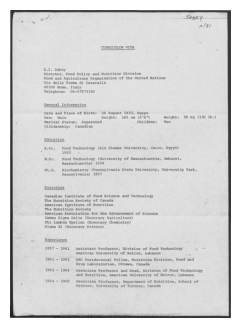

d:\codes\Post-training-of-DeepSeek-OCR\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cach

[Prompt]: <image>
Based on the visual text, How many children does he have?...
[Image Size]: (366, 512)


The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.46 `position_ids` will be removed and `position_embeddings` will be mandatory.


BASE:  torch.Size([1, 256, 1280])
NO PATCHES
>>> [Output]:
He has 2 children.

==================== Sample 1 ====================


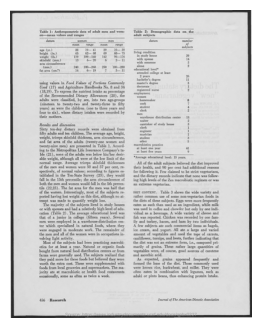

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[Prompt]: <image>
What is the name of the journal given?
Answer strictly based on the content shown in the ima...
[Image Size]: (400, 511)
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
>>> [Output]:
Table 1: Anthropometric data of adult men and women

==================== Sample 2 ====================


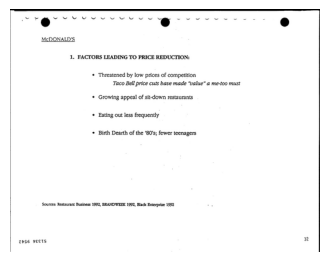

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[Prompt]: <image>
Based on the visual text, What type of restaurants are having a growing appeal?...
[Image Size]: (512, 401)
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
>>> [Output]:
Sit-down restaurants are having a growing appeal.


In [6]:
import types
import gc

gc.collect()
torch.cuda.empty_cache()

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model.infer_memory = types.MethodType(infer_memory, model)
model = model.eval()


for i in range(min(3, len(train_dataset))):
    print(f"\n{'='*20} Sample {i} {'='*20}")
    
    item = train_dataset[i]
    
    pil_image = item['image']
    plt.figure(figsize=(4, 4))
    plt.imshow(pil_image)
    plt.axis('off')
    plt.show()

    messages = item['messages']
    prompt_content = "Convert to markdown" 
    

    for msg in messages:
        if msg['role'].lower() in ['user', 'human']:
            prompt_content = msg['content']
            break
            
    if '<image>' not in prompt_content:
        prompt_content = "<image>\n" + prompt_content
        
    print(f"[Prompt]: {prompt_content[:100]}...")
    print(f"[Image Size]: {pil_image.size}")


    try:
        result = model.infer_memory(tokenizer, prompt_content, pil_image)
        print(">>> [Output]:")
        print(result[:500] + "..." if len(result) > 500 else result)
    except Exception as e:
        print(f"❌ 推理出错: {e}")

In [7]:
import torch
import sys
import math
import os
from transformers import TrainingArguments, Trainer, AutoModel, AutoTokenizer
from peft import LoraConfig, get_peft_model
from PIL import ImageOps

# =====================================================
# ⚠️ 必须步骤：设置环境变量以减少显存碎片
# =====================================================
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# =====================================================
# 1. 重新加载模型 (确保干净的状态)
# =====================================================
model_path = "deepseek-ai/DeepSeek-OCR"

print("🔄 Reloading model to clean state...")
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True, use_fast=False)

# 加载模型
model = AutoModel.from_pretrained(
    model_path,
    trust_remote_code=True,
    use_safetensors=True,
    torch_dtype=torch.bfloat16
).cuda()

# 【关键修复 1】: 显式关闭梯度检查点 (解决 in-place error 的核心)
model.config.gradient_checkpointing = False 
if hasattr(model, "gradient_checkpointing_disable"):
    model.gradient_checkpointing_disable()

# 【关键修复 2】: 显式冻结所有参数，防止 Embedding 层被意外追踪
for param in model.parameters():
    param.requires_grad = False

# 获取工具函数
remote_module = sys.modules[model.__module__]

# =====================================================
# 2. 配置 LoRA
# =====================================================
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# 应用 LoRA (这会自动让 LoRA 层 requires_grad=True)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# 再次确保 use_cache 关闭
model.config.use_cache = False 

# =====================================================
# 3. Data Collator
# =====================================================
class DataCollatorForDeepSeekOCR:
    def __init__(self, tokenizer, remote_module_obj):
        self.tokenizer = tokenizer
        self.remote_module = remote_module_obj
        self.format_messages = self.remote_module.format_messages
        self.text_encode = self.remote_module.text_encode
        self.dynamic_preprocess = self.remote_module.dynamic_preprocess
        self.image_transform = self.remote_module.BasicImageTransform(
            mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), normalize=True
        )
        self.image_token_id = 128815 
        self.base_size = 1024
        self.patch_size = 16
        self.downsample_ratio = 4
        self.ignore_index = -100

    def __call__(self, instances):
        input_ids_list = []
        labels_list = []
        images_list = []
        images_seq_mask_list = []
        images_spatial_crop_list = []
        
        for instance in instances:
            pil_img = instance['image']
            messages = instance['messages']
            
            if pil_img.size[0] <= 640 and pil_img.size[1] <= 640:
                crop_ratio = [1, 1]
                images_crop_raw = []
            else:
                images_crop_raw, crop_ratio = self.dynamic_preprocess(pil_img)
            
            global_view = ImageOps.pad(pil_img, (self.base_size, self.base_size),
                                    color=tuple(int(x * 255) for x in self.image_transform.mean))
            global_view_tensor = self.image_transform(global_view).to(torch.bfloat16)
            
            local_view_tensors = []
            if crop_ratio[0] > 1 or crop_ratio[1] > 1:
                for crop in images_crop_raw:
                    local_view_tensors.append(self.image_transform(crop).to(torch.bfloat16))
            
            if local_view_tensors:
                images_crop = torch.stack(local_view_tensors, dim=0)
            else:
                images_crop = torch.zeros((1, 3, self.base_size, self.base_size), dtype=torch.bfloat16)
            
            images_list.append((images_crop, global_view_tensor.unsqueeze(0)))
            images_spatial_crop_list.append(crop_ratio)
            
            num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)
            num_queries = math.ceil((640 // self.patch_size) / self.downsample_ratio)
            width_crop_num, height_crop_num = crop_ratio
            
            img_tokens = ([self.image_token_id] * num_queries_base + [self.image_token_id]) * num_queries_base
            img_tokens += [self.image_token_id]
            
            if width_crop_num > 1 or height_crop_num > 1:
                 img_tokens += ([self.image_token_id] * (num_queries * width_crop_num) + [self.image_token_id]) * (num_queries * height_crop_num)
            
            user_content = messages[0]['content']
            assistant_content = messages[1]['content']
            
            conversation_input = [
                {"role": "<|User|>", "content": user_content.replace("<image>", ""), "images": []},
                {"role": "<|Assistant|>", "content": ""}
            ]
            prompt_str = self.format_messages(conversations=conversation_input, sft_format='plain', system_prompt='')
            
            prompt_parts = prompt_str.split("<image>")
            
            user_ids = []
            user_mask = [] 
            
            if len(prompt_parts) > 0 and prompt_parts[0]:
                ids = self.text_encode(self.tokenizer, prompt_parts[0], bos=True, eos=False)
                user_ids.extend(ids)
                user_mask.extend([False] * len(ids))
            else:
                user_ids.append(self.tokenizer.bos_token_id)
                user_mask.append(False)
                
            user_ids.extend(img_tokens)
            user_mask.extend([True] * len(img_tokens))
            
            if len(prompt_parts) > 1:
                ids = self.text_encode(self.tokenizer, prompt_parts[1], bos=False, eos=False)
                user_ids.extend(ids)
                user_mask.extend([False] * len(ids))
            
            ans_ids = self.text_encode(self.tokenizer, assistant_content, bos=False, eos=True)
            
            input_ids = user_ids + ans_ids
            labels = [self.ignore_index] * len(user_ids) + ans_ids
            seq_mask = user_mask + [False] * len(ans_ids)
            
            max_len = 2048
            if len(input_ids) > max_len:
                input_ids = input_ids[:max_len]
                labels = labels[:max_len]
                seq_mask = seq_mask[:max_len]

            input_ids_list.append(torch.LongTensor(input_ids))
            labels_list.append(torch.LongTensor(labels))
            images_seq_mask_list.append(torch.BoolTensor(seq_mask))
            
        input_ids_padded = torch.nn.utils.rnn.pad_sequence(
            input_ids_list, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels_padded = torch.nn.utils.rnn.pad_sequence(
            labels_list, batch_first=True, padding_value=self.ignore_index
        )
        images_seq_mask_padded = torch.nn.utils.rnn.pad_sequence(
            images_seq_mask_list, batch_first=True, padding_value=False
        )
        images_spatial_crop = torch.tensor(images_spatial_crop_list, dtype=torch.long)
        
        return {
            "input_ids": input_ids_padded,
            "labels": labels_padded,
            "images": images_list,
            "images_seq_mask": images_seq_mask_padded,
            "images_spatial_crop": images_spatial_crop,
            "attention_mask": input_ids_padded.ne(self.tokenizer.pad_token_id)
        }

# =====================================================
# 4. 训练参数
# =====================================================
training_args = TrainingArguments(
    output_dir="./model",
    num_train_epochs=1,                  
    per_device_train_batch_size=2,       
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    weight_decay=0.01,
    warmup_ratio=0.03,
    logging_steps=1,
    save_steps=50,
    save_total_limit=1,
    fp16=False,
    bf16=True,
    dataloader_num_workers=0,
    remove_unused_columns=False,
    report_to="none",
    gradient_checkpointing=False 
)

# =====================================================
# 5. 启动训练
# =====================================================
data_collator = DataCollatorForDeepSeekOCR(tokenizer, remote_module)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)

print("🚀 Starting SFT Training...")
print("NOTE: Gradient Checkpointing is DISABLED to prevent in-place errors.")
train_result = trainer.train()
trainer.save_model()
print(f"✅ Training finished. Model saved to {training_args.output_dir}")

🔄 Reloading model to clean state...


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 77,509,632 || all params: 3,413,615,872 || trainable%: 2.2706
🚀 Starting SFT Training...
NOTE: Gradient Checkpointing is DISABLED to prevent in-place errors.


  0%|          | 0/250 [00:00<?, ?it/s]

BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 6.5556, 'grad_norm': 65.07292175292969, 'learning_rate': 2.5e-05, 'epoch': 0.0}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 6.3197, 'grad_norm': 50.93037796020508, 'learning_rate': 5e-05, 'epoch': 0.01}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 3.568, 'grad_norm': 29.51727294921875, 'learning_rate': 7.500000000000001e-05, 'epoch': 0.01}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 1.6149, 'grad_norm': 14.204574584960938, 'learning_rate': 0.0001644628099173554, 'epoch': 0.2}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 2.3413, 'grad_norm': 19.700119018554688, 'learning_rate': 0.00016363636363636366, 'epoch': 0.21}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 2.569, 'grad_norm': 20.827392578125, 'learning_rate': 0.0001628099173553719, 'epoch': 0.21}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.S

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /deepseek-ai/DeepSeek-OCR/resolve/main/config.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)')))"), '(Request ID: e99b0fb8-1b84-418b-9c58-c190e3d6ab37)')' thrown while requesting HEAD https://huggingface.co/deepseek-ai/DeepSeek-OCR/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /deepseek-ai/DeepSeek-OCR/resolve/main/config.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)')))"), '(Request ID: 5b633bf5-567d-4dcd-862c-135a342bf46e)')' thrown while requesting HEAD https://huggingface.co/deepseek-ai/DeepSeek-OCR/resolve/main/config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', po

BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 0.7453, 'grad_norm': 11.363941192626953, 'learning_rate': 0.0001231404958677686, 'epoch': 0.4}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 1.8656, 'grad_norm': 18.010778427124023, 'learning_rate': 0.00012231404958677685, 'epoch': 0.41}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 0.8467, 'grad_norm': 26.52142333984375, 'learning_rate': 0.00012148760330578513, 'epoch': 0.41}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  tor

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /deepseek-ai/DeepSeek-OCR/resolve/main/config.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)')))"), '(Request ID: 0bcdb6e0-371f-480d-be05-05fd8da64b44)')' thrown while requesting HEAD https://huggingface.co/deepseek-ai/DeepSeek-OCR/resolve/main/config.json
Retrying in 1s [Retry 1/5].
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 1.7393, 'grad_norm': 21.77703285217285, 'learning_rate': 8.181818181818183e-05, 'epoch': 0.6}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 1.6684, 'grad_norm': 23.23644256591797, 'learning_rate': 8.099173553719009e-05, 'epoch': 0.61}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 1.3313, 'grad_norm': 16.73198127746582, 'learning_rate': 8.016528925619836e-05, 'epoch': 0.61}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.S

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 0.7857, 'grad_norm': 11.072754859924316, 'learning_rate': 4.049586776859504e-05, 'epoch': 0.8}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 1.1158, 'grad_norm': 27.454355239868164, 'learning_rate': 3.9669421487603306e-05, 'epoch': 0.81}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
{'loss': 0.7012, 'grad_norm': 13.99096965789795, 'learning_rate': 3.884297520661157e-05, 'epoch': 0.81}
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torch.Size([1, 256, 1280])
NO PATCHES
BASE:  torc

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /deepseek-ai/DeepSeek-OCR/resolve/main/config.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)')))"), '(Request ID: bcf1222b-fea1-4caa-9b12-368100e759ad)')' thrown while requesting HEAD https://huggingface.co/deepseek-ai/DeepSeek-OCR/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/resolve-cache/models/deepseek-ai/DeepSeek-OCR/9f30c71f441d010e5429c532364a86705536c53a/config.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)')))"), '(Request ID: d8e75a58-5511-404b-894f-4fd346295409)')' thrown while requesting HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/DeepSeek-OCR/9f30c71f441d010e5429c532364a86705536c

{'train_runtime': 1615.3661, 'train_samples_per_second': 0.619, 'train_steps_per_second': 0.155, 'train_loss': 1.4497823936343193, 'epoch': 1.0}


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


✅ Training finished. Model saved to ./model
